# Correlation between Sharma models and sPlot

In [30]:
from src.conf.conf import get_config


cfg = get_config()

In [31]:
import pandas as pd

pred = (
    pd.read_csv(
        "/mnt/gsdata/projects/panops/inferenceresult_withtaxa.csv", index_col=0
    ).drop(
        columns=[
            "image",
            "pft",
            "Species",
            "Kingdom",
            "Phylum",
            "Class",
            "Order",
            "Family",
            "Genus",
        ]
    )
    .reset_index(drop=True)
)

pred.head()

,latitude,longitude,X11_true,X50_true,X13_true,X47_true,X18_true,X3113_true,X46_true,X21_true,X11_pred,X50_pred,X13_pred,X47_pred,X18_pred,X3113_pred,X46_pred,X21_pred
0,34.04164,-118.75382,6.658405,3.087923,487.27390,0.343530,4.267365,404.27290,0.363895,0.559313,4.649353,5.344338,483.35428,0.348799,3.468139,133.96999,0.541114,0.913209
1,30.56922,-94.94951,40.300087,0.640547,452.35650,0.107740,0.113465,259.15524,0.193335,0.001461,54.065470,0.397057,442.75275,0.078284,0.140406,233.13930,0.165506,0.001030
2,38.64312,-122.77681,18.024319,1.873441,434.02188,0.177487,0.347974,2972.36280,0.246529,0.003411,20.772749,1.342314,426.17280,0.170424,0.220198,288.62753,0.259712,0.004816
3,40.96367,-81.33122,14.628735,0.916192,415.22140,0.267856,0.214478,331.35138,0.173195,0.008341,20.374573,1.060553,399.09528,0.217466,0.330928,303.52582,0.185314,0.010413
4,32.99591,-96.62907,19.042921,1.842616,464.56600,0.241688,0.352798,1817.61940,0.208809,0.026467,21.970524,1.654610,459.28067,0.208234,0.234546,865.43070,0.218797,0.011382


/home/dl1070/projects/cit-sci-traits/src/utils/df_utils.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y"] = (df[lat] + 90) // res * res - 90 + res / 2
/home/dl1070/projects/cit-sci-traits/src/utils/df_utils.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["x"] = (df[lon] + 180) // res * res - 180 + res / 2
/home/dl1070/projects/cit-sci-traits/src/utils/df_utils.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

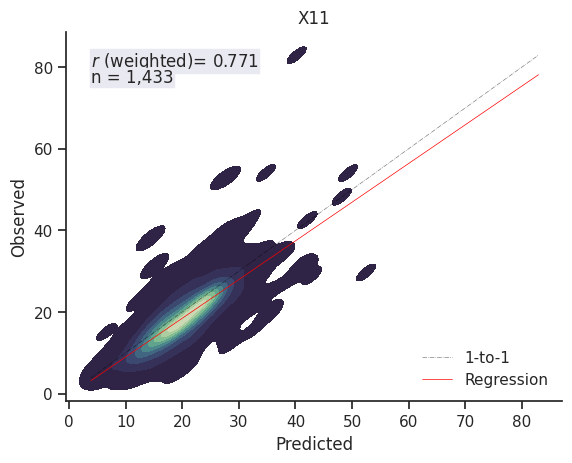

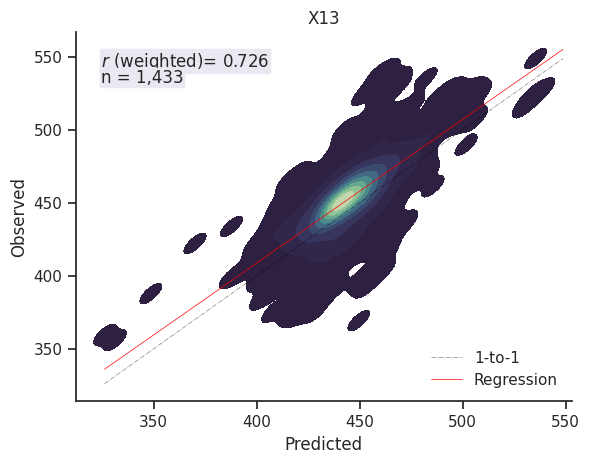

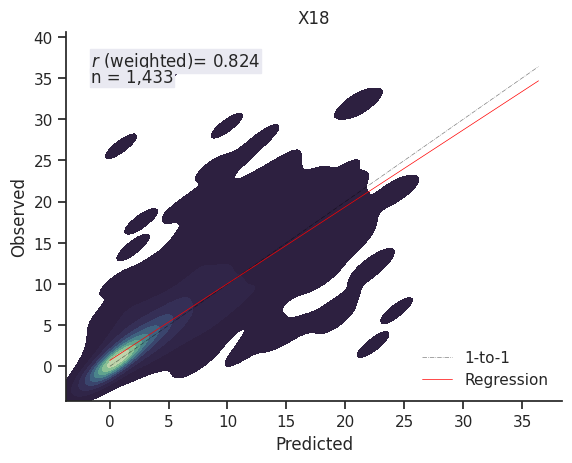

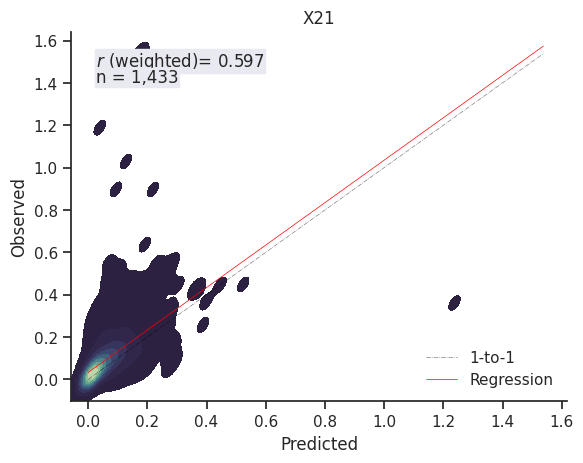

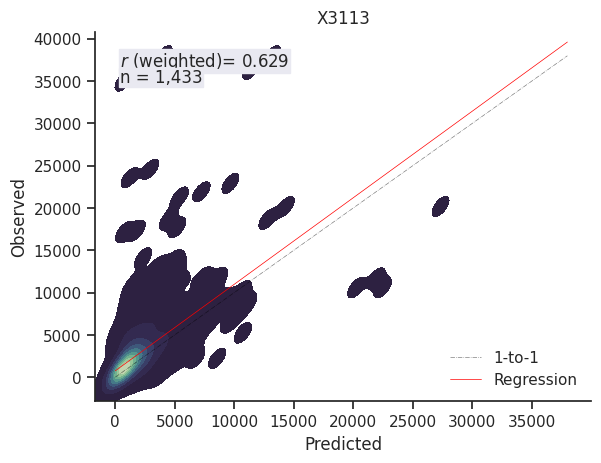

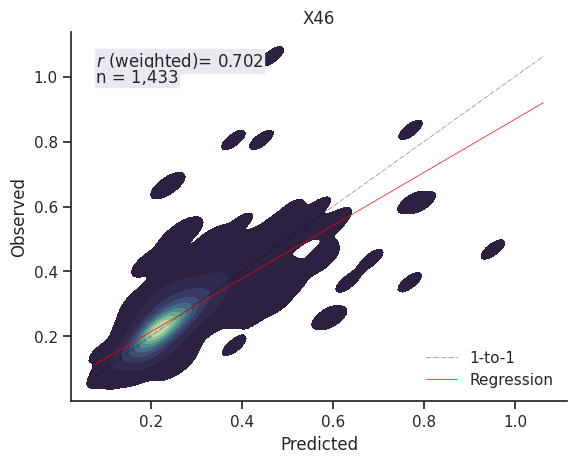

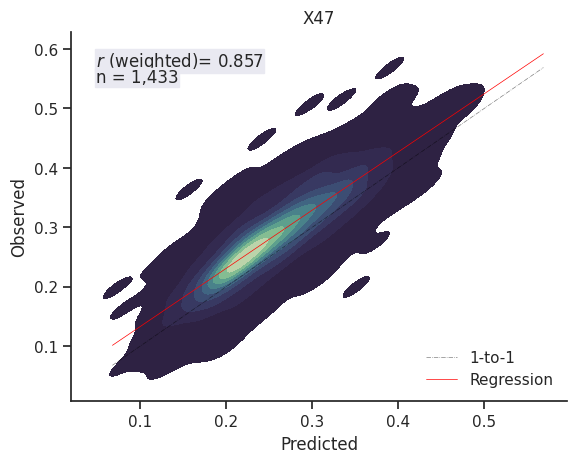

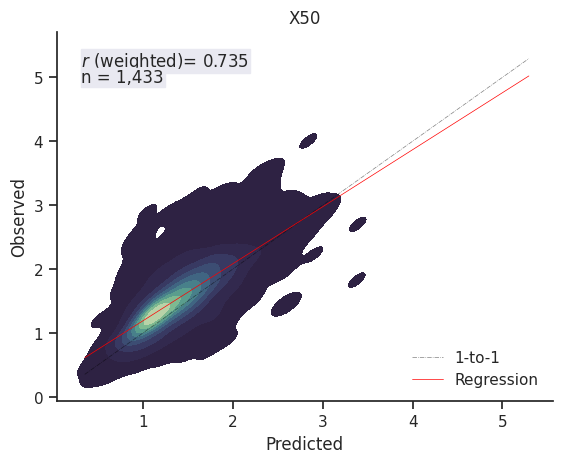

In [33]:
from pathlib import Path
from matplotlib import pyplot as plt
from src.utils.df_utils import global_grid_df
from src.utils.spatial_utils import lat_weights, weighted_pearson_r
from src.visualization.model_assessment import plot_observed_vs_predicted
import seaborn as sns


trait_cols = [col for col in pred.columns if col.startswith("X")]
true_cols = sorted([col for col in trait_cols if col.endswith("true")])
pred_cols = sorted([col for col in trait_cols if col.endswith("pred")])

all_stats_path = Path("share", "sharma", "all_stats.csv")

if all_stats_path.exists():
    all_stats = pd.read_csv(all_stats_path)
else:
    all_stats = pd.DataFrame({"trait": [], "resolution": [], "r": []})

for true_col, pred_col in zip(true_cols, pred_cols):
    grid_stat = ["mean"]
    true_df = global_grid_df(
        pred[["longitude", "latitude", true_col]],
        true_col,
        lon="longitude",
        lat="latitude",
        res=cfg.target_resolution,
        stats=grid_stat,
    ).rename(columns={"mean": true_col})

    pred_df = global_grid_df(
        pred[["longitude", "latitude", pred_col]],
        pred_col,
        lon="longitude",
        lat="latitude",
        res=cfg.target_resolution,
        stats=grid_stat,
    ).rename(columns={"mean": pred_col})

    obs_vs_pred = true_df.join(pred_df, how="inner").rename(
        columns={true_col: "observed", pred_col: "predicted"}
    )

    # Get unique values of the "y" index
    lat_wts = lat_weights(
        obs_vs_pred.index.get_level_values("y").unique().values, cfg.target_resolution
    )
    weighted_r = weighted_pearson_r(obs_vs_pred, lat_wts)
    trait_stats = pd.DataFrame(
        {
            "trait": [true_col.split("_")[0]],
            "resolution": [cfg.target_resolution],
            "r": [weighted_r],
        }
    )

    all_stats = pd.concat([all_stats, trait_stats], ignore_index=True).drop_duplicates()

    with sns.plotting_context("notebook"), sns.axes_style("ticks"):
        fig, ax = plt.subplots(1, 1)

        ax = plot_observed_vs_predicted(
            ax,
            obs_vs_pred.observed,
            obs_vs_pred.predicted,
            true_col.split("_")[0],
            log=False,
            density=True,
            show_r=True,
            manual_r=weighted_r,
            r_weighted=True,
        )

        sns.despine()

        fig_path = Path(
            "share",
            "sharma",
            "plots",
            f"{true_col.split('_')[0]}_obs_vs_pred_{cfg.model_res}.png",
        )
        fig_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(fig_path, dpi=300)

all_stats.to_csv(all_stats_path, index=False)